In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
import re


/var/folders/q1/679dhjnx7ys1stvtjt8hssw80000gn/T/ipykernel_16306/173386614.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
data = pd.read_csv('data/raw/output.csv')

/var/folders/q1/679dhjnx7ys1stvtjt8hssw80000gn/T/ipykernel_16306/3433615418.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/raw/output.csv')


In [107]:
data2 = data.copy()
data2.head()

# data2 = data2.drop_duplicates(subset=[
#     "External reference",
#     "Address"
# ])
# Dropping specified columns and assigning the result back to data2
data2 = data2.drop(columns=["Property ID", "Type of sale", "Address", "Tenement building", "Swimming pool"])

data2.dropna(axis='columns', thresh=0.79*len(data2), inplace=True)
data2.dropna(axis='rows', inplace=True)
data2["Price"] = data2["Price"].str.replace("€", "")


data2['Locality name'] = data2['Locality name'].apply(urllib.parse.unquote)
try:
    data2["Price"] = data2["Price"].str.replace("Starting price : ", "")
    data2["Price"] = data2["Price"].astype(int)
except:
    data2 = data2[~data2["Price"].str.contains(r'\d+\s+per\s+month')]
    data2["Price"] = data2["Price"].str.replace(r'\D', '').astype(int)

pd.set_option('display.float_format', lambda x: '%.2f' % x)

data2.rename(columns={"How many fireplaces?": "Fireplace"}, inplace=True)


bins = pd.cut(
    x = data2["Price"],
    bins=[0, 100000, 500000, 1000000, data2["Price"].max()+1],
    labels=["low", "medium", "high", "exorbitant"]
)
data2["Price bins"] = bins

energy_class_mapping = {
    "G": 0,
    "F": 1,
    "F_C": 1,
    "E": 2,
    "D": 3,
    "C": 4,
    "B": 5,
    "A": 6,
    "A+": 7,
    "A++": 8,
    "A+++": 9,
}

data2["Energy class"] = data2["Energy class"].map(energy_class_mapping)




In [103]:
#Q1
'''How many observations and features do you have?" - 30 but we keep only 12'''
print(data.shape)

#Q3
'''which variables would you delete and why?(many: all except:
'Locality name', 'Postal code', 'Price', 'Type of property', 'Subtype of property', 'Bedrooms', 'Living area', 'Kitchen type', 'Furnished', 'Fireplace', 'Energy class', 'Price bins' 
because we find them most reliable'''
data2.columns

#Q4
'''What variables are most subject to outliers?: Again there are many of them but the most garbage ones are:
Yearly theoretical total energy consumption, CO₂ emission, Garden surface'''
series = data.isna().sum()
series = series.sort_values(ascending=False)
# print(series)


#Q5
'''How many qualitative and quantitative variables are there? How would you transform the qualitative values into numerical values?
There are 8 numeric and 4 string values, we had more but we converthed them with .astype(int) method'''
print(data2.dtypes)


#Q6
'''What is the correlation between the variables and the price? Why do you think some variables are more correlated than others?'''


#Q7
'''How are the variables themselves correlated to each other? Can you find groups of variables that are correlated together?'''
#Q8
'''How are the number of properties distributed according to their surface?'''
#Q9


(18065, 30)
Locality name            object
Postal code               int64
Price                     int64
Type of property         object
Subtype of property      object
Bedrooms                float64
Living area             float64
Kitchen type              int64
Furnished                 int64
Fireplace                 int64
Energy class              int64
Price bins             category
dtype: object


In [108]:
provinces = {
    "Antwerp": "2000-2999",
    "Brussels": "1000-1299",
    "East Flanders": "9000-9999",
    "Flemish Brabant": ["1500-1999", "3000-3499"],
    "Hainaut": ["6000-6599", "7000-7999"],
    "Liege": "4000-4999",
    "Limburg": "3500-3999",
    "Luxembourg": "6600-6900",
    "Namur": "5000-5999",
    "Walloon Brabant": "1300-1499",
    "West Flanders": "8000-8999"
}
for index, postal_code in data2["Postal code"].items():
    for province, postal_range in provinces.items():
        if isinstance(postal_range, list):
            for range_str in postal_range:
                range_start, range_end = map(int, range_str.split("-"))
                if postal_code in range(range_start, range_end + 1):
                    data2.loc[index, "Provinces"] = province
        else:
            range_start, range_end = map(int, postal_range.split("-"))
            if postal_code in range(range_start, range_end + 1):
                data2.loc[index, "Provinces"] = province


# Calculate the average price per locality
# Assuming data2 contains the necessary columns like 'Provinces', 'Price', etc.

# Calculate the average price per locality
localities = data2.groupby('Provinces')
average_price_per_locality = localities['Price'].mean()

# Create a DataFrame to display the results
average_price = pd.DataFrame({'Province': average_price_per_locality.index, 'Average price': average_price_per_locality.values})
average_price.head(10)



,Province,Average price
0,Antwerp,473451.96
1,Brussels,274550.00
2,East Flanders,445834.66
3,Flemish Brabant,410384.62
4,Hainaut,222295.45
5,Liege,279681.48
6,Limburg,405245.45
7,Luxembourg,243833.33
8,Namur,217666.67
9,Walloon Brabant,474000.00


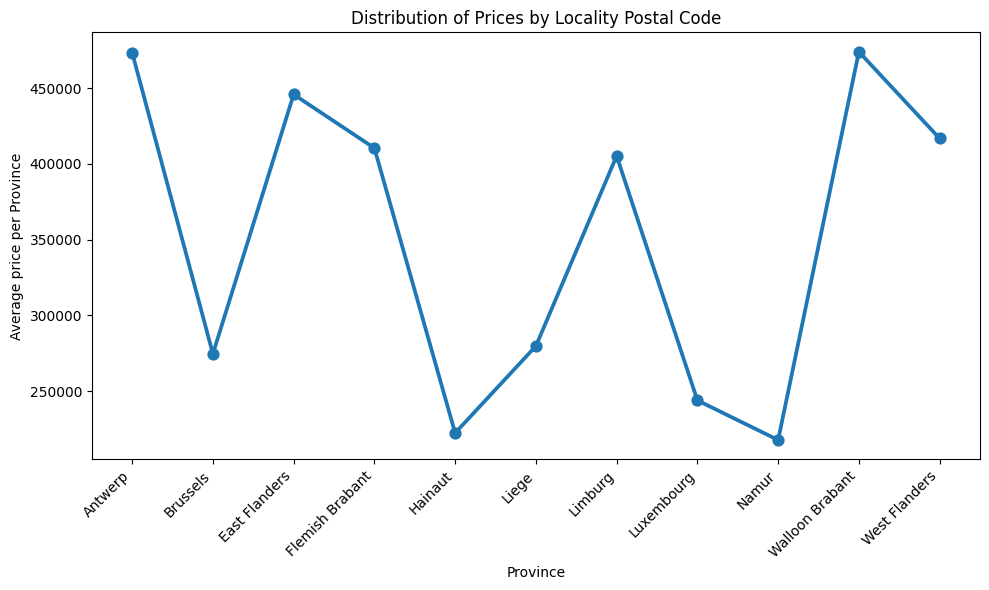

In [109]:
plt.figure(figsize=(10, 6))


sns.pointplot(data=average_price, x="Province", y="Average price")
plt.xlabel("Province")
plt.ylabel("Average price per Province")
plt.title("Distribution of Prices by Locality Postal Code")

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()

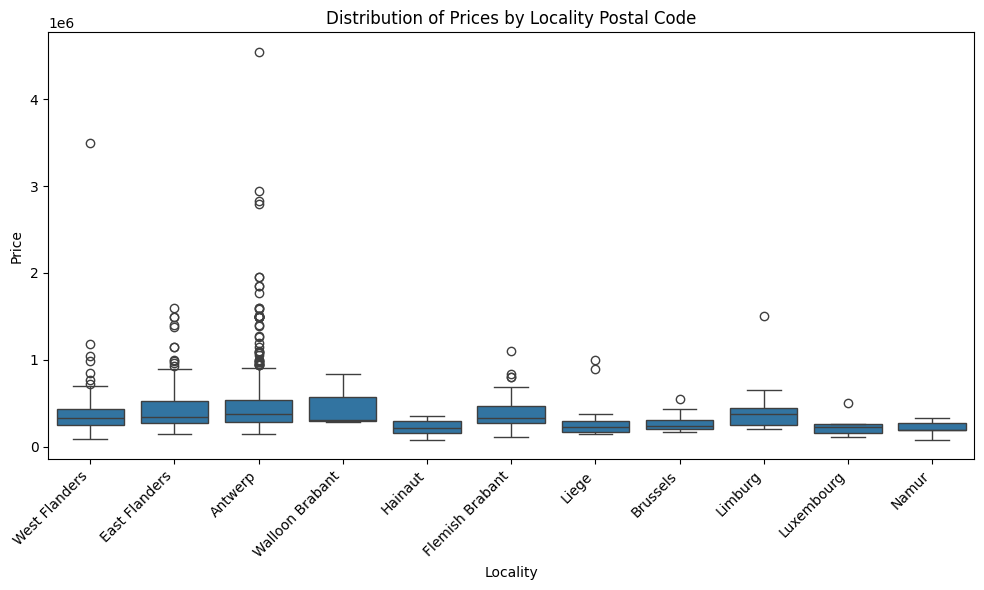

In [110]:
plt.figure(figsize=(10, 6))


sns.boxplot(data=data2, x="Provinces", y="Price")
plt.xlabel("Locality")
plt.ylabel("Price")
plt.title("Distribution of Prices by Locality Postal Code")

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()

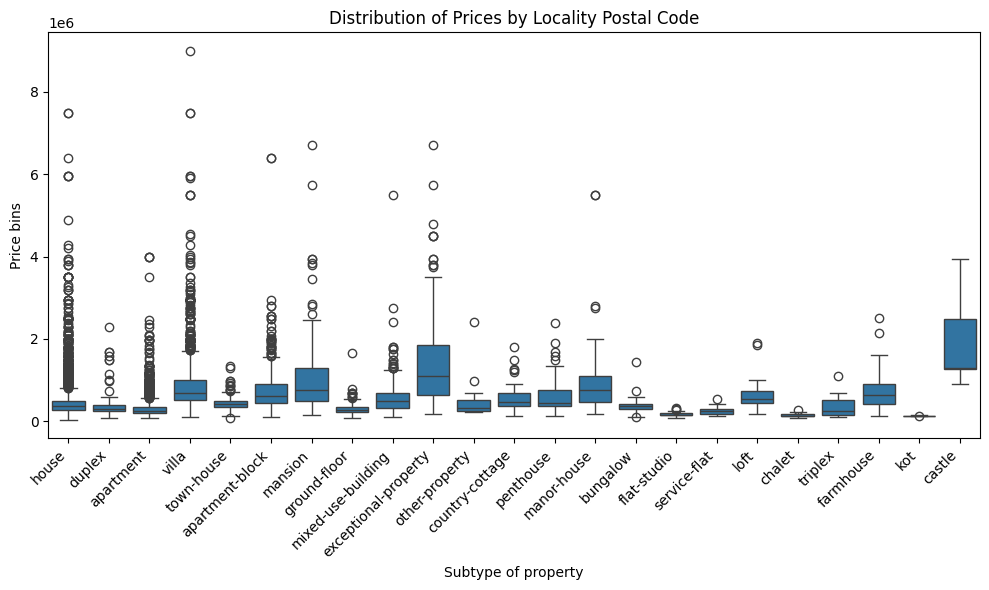

In [32]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=data2, x="Subtype of property", y="Price")
plt.xlabel("Subtype of property")
plt.ylabel("Price bins")
plt.title("Distribution of Prices by Locality Postal Code")

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()


In [111]:
data2.head()

,Url,Locality name,Postal code,Price,Type of property,Subtype of property,Bedrooms,Living area,Kitchen type,Furnished,Fireplace,Bathrooms,Energy class,External reference,Price bins,Provinces
0,https://www.immoweb.be/en/classified/house/for...,neufchâteau,6840,330000,house,house,4.00,203.00,1,0,0,1.00,2,5844235,medium,NaN
1,https://www.immoweb.be/en/classified/house/for...,roosdaal,1760,497000,house,house,4.00,180.00,1,0,0,1.00,6,5866041,medium,NaN
2,https://www.immoweb.be/en/classified/house/for...,bastogne,6600,399000,house,house,4.00,190.00,1,0,0,1.00,5,5865989,medium,NaN
3,https://www.immoweb.be/en/classified/apartment...,antwerp,2140,215000,appartment,apartment,3.00,106.00,1,0,0,1.00,5,5841265,medium,NaN
4,https://www.immoweb.be/en/classified/house/for...,hemiksem,2620,299000,house,house,2.00,100.00,1,0,0,1.00,6,5823673,medium,NaN


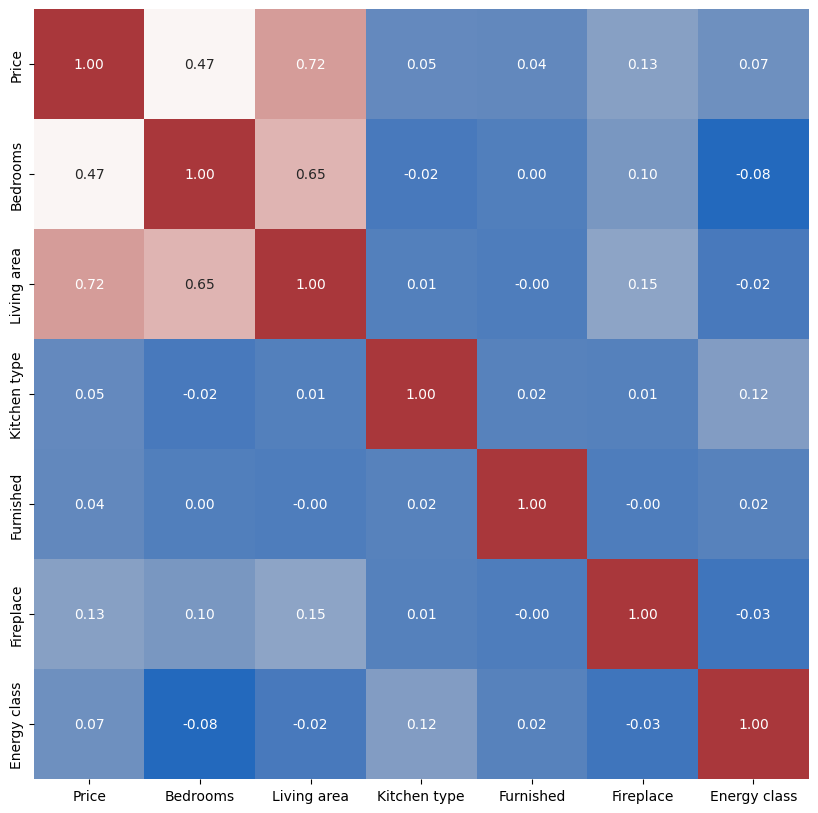

In [62]:

data2["Postal code"] = data2["Postal code"].astype(str)

numerical_cols = data2.select_dtypes(include=["float", "int"]).columns
numerical_data = pd.DataFrame()
numerical_data[numerical_cols] = data2[numerical_cols]

plt.figure(figsize=(10, 10))
sns.heatmap(numerical_data.corr(), annot=True, cbar=False, cmap="vlag", fmt=".2f")
plt.show()

